# Predicting survival post alloHCT using Machine Learning.

**Author:** Asif Adil  
**Date:** November 18, 2025  
**Last Modified:** November 18, 2025

## Abstract

This notebook develops and evaluates machine learning models to predict post-alloHCT survival outcomes at multiple time horizons (100 days, 1 year, 2 years, 3 years). We employ a comprehensive pipeline with feature selection, preprocessing, hyperparameter tuning via grid search, and calibrated classifiers across three model families (Logistic Regression, Gradient Boosting, Random Forest). Model performance is assessed using stratified cross-validation with metrics including AUROC, AUPRC, and calibration curves, with SHAP analysis for interpretability.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import glob, os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# remove warnings
import warnings
warnings.filterwarnings('ignore')

from pyprojroot import here

In [3]:
# Add the project root to sys.path
sys.path.append(str(here()))

from hspc.config import get_config
config = get_config()

In [4]:
import os, warnings, math, json
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, precision_recall_curve,
    roc_curve
)
from sklearn.calibration import calibration_curve
import joblib
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter


from allosurv.allosurv import ( make_preprocessor, 
                               make_models_and_grids,
                               make_labels,
                               evaluate,
                               plot_roc_pr_cal,
                               plot_shap_for_horizon,
                               plot_performance_curves,
)

In [5]:
HORIZONS = {'100d':100,'1y':365,'2y':730,'3y':1095}

In [6]:
df = pd.read_csv(here() / config.data_processed / "Aryans_Top25medications_processed.csv")
df.head(5)

,record_id,pat_gender,pat_ethnicity,vital_status,survival_days,disease_category,transplant_age,stem_cell_source,donor_type,recipient_type,...,potassiumchloride,amlodipine,lorazepam,melatonin,loperamide,ursodiol,acetaminophen,olanzapine,polyethyleneglycol,gabapentin
0,1,0,Not Hispanic or Latino (Race:Black or African ...,0,211,Severe aplastic anemia (SAA),12,MRD,A+,O+,...,0,0,1,0,0,0,1,0,0,0
1,2,1,Not Hispanic or Latino (Race:White),0,210,Acute lymphoblastic leukemia (ALL),37,MUD,O+,O+,...,0,0,1,0,0,1,0,0,0,0
2,3,0,Hispanic or Latino (Race:White),0,210,Acute Myeloid Leukemia (AML),71,MUD,O+,A+,...,0,0,0,1,0,0,0,1,0,0
3,4,1,Not Hispanic or Latino (Race:White),0,208,Non-Hodgkin lymphoma (NHL),64,MUD,A+,O+,...,1,0,0,0,0,1,0,0,0,0
4,5,1,Not Hispanic or Latino (Race:White),0,204,Acute Myeloid Leukemia (AML),50,MRD,O+,O-,...,1,0,0,0,0,0,0,0,0,0


In [7]:
cat_cols = ['pat_gender','pat_ethnicity','disease_category','stem_cell_source','donor_type','recipient_type','conditioning_type',
            'acyclovir', 'fluconazole', 'sulfamethoxazole-trimethoprim',
       'tacrolimus', 'mycophenolatemofetil', 'ondansetron', 'sirolimus',
       'letermovir', 'prochlorperazine', 'pantoprazole', 'magnesiumoxide',
       'multivitamin/supplement', 'oxycodone', 'promethazine',
       'cholecalciferol', 'potassiumchloride', 'amlodipine', 'lorazepam',
       'melatonin', 'loperamide', 'ursodiol', 'acetaminophen', 'olanzapine',
       'polyethyleneglycol', 'gabapentin']

In [8]:
# Keep obvious structured columns: numeric + short categorical
num_candidates = [c for c in df.columns if any(k in c.lower() for k in ['age','dose','pre','anc','wbc','rbc','plt','hgb','mcv', 'hla_match'])]
# add explicitly if present
for c in ['pat_age','transplant_age','cd34_dose','tbi_dose_max','rbc_pre','wbc_pre','plt_pre','hgb_pre','anc_pre','mcv_pre']:
    if c in df.columns and c not in num_candidates: num_candidates.append(c)

cat_candidates = [c for c in cat_cols if c in df.columns]
# cat_candidates = [c for c in ['pat_gender','pat_ethnicity','disease_category','stem_cell_source','donor_type', 'hla_matching','recipient_type','conditioning_type'] if c in df.columns]

feature_cols = sorted(set(num_candidates + cat_candidates))
# remove rbc_mo1.1  and pat_age from the features because it is redundant with rbc_pre
if 'rbc_mo1.1' in feature_cols:
    feature_cols.remove('rbc_mo1.1')
if 'pat_age' in feature_cols:
    feature_cols.remove('pat_age')
X = df[feature_cols].copy()
print('Using', len(feature_cols), 'features')

Using 70 features


In [9]:
all_results = []
best_models = {}
best_model_performances = {}
all_metrics = {} # for later usage of plotting if requred

for hname, T in HORIZONS.items():
    print(f'\n=== Horizon {hname} (T={T}) ===')
    y = make_labels(df, T)
    m = ~y.isna()
    Xh, yh = X[m], y[m].astype(int)

    pre = make_preprocessor(Xh)
    models, grids = make_models_and_grids()
    outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_metrics = []
    y_all_prob, y_all_true = [], []

    for k, (tr, te) in enumerate(outer.split(Xh, yh), start=1):
        Xtr, Xte = Xh.iloc[tr], Xh.iloc[te]
        ytr, yte = yh.iloc[tr], yh.iloc[te]

        best_auc, best_model = -np.inf, None
        for mname, clf in models.items():
            pipe = Pipeline([('prep', pre), ('clf', clf)])
            gs = GridSearchCV(pipe, grids[mname], scoring='roc_auc', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1, refit=True)
            gs.fit(Xtr, ytr)
            cal = CalibratedClassifierCV(gs.best_estimator_, cv=3, method='isotonic')
            cal.fit(Xtr, ytr)
            yprob = cal.predict_proba(Xte)[:,1]
            auc = roc_auc_score(yte, yprob)
            if auc > best_auc:
                best_auc, best_model = auc, cal

        yprob = best_model.predict_proba(Xte)[:,1]
        ypred = (yprob>=0.5).astype(int)
        metr = evaluate(yte, yprob, ypred); metr['Fold']=k; fold_metrics.append(metr)
        y_all_prob.extend(yprob.tolist()); y_all_true.extend(yte.tolist())

    res = pd.DataFrame(fold_metrics).mean(numeric_only=True)
    print('Mean metrics over 5 folds:\n', res[['AUROC','AUPRC','Brier','Accuracy','Precision','Recall','F1','BalancedAcc']])

    # Refit best family on all labeled data
    # Pick family by higher mean AUROC from the two models trained on full data with CV
    fam_scores = {}
    for mname, clf in models.items():
        pipe = Pipeline([('prep', pre), ('clf', clf)])
        gs = GridSearchCV(pipe, grids[mname], scoring='roc_auc', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1, refit=True)
        gs.fit(Xh, yh)
        fam_scores[mname] = gs.best_score_
    best_family = max(fam_scores, key=fam_scores.get)
    gs = GridSearchCV(Pipeline([('prep', pre), ('clf', models[best_family])]), grids[best_family], scoring='roc_auc', cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), n_jobs=-1, refit=True)
    gs.fit(Xh, yh)
    cal_full = CalibratedClassifierCV(gs.best_estimator_, cv=3, method='isotonic')
    cal_full.fit(Xh, yh)
    
    # for each best model, store its performance metrics like AUROC, AUPRC, etc. to plot later
    best_model_performances[hname] = evaluate(np.array(y_all_true), np.array(y_all_prob), (np.array(y_all_prob)>=0.5).astype(int))
    performance_df = pd.DataFrame.from_dict(best_model_performances, orient='index')
    # print(f'\nBest model performances for horizon {hname}:\n', performance_df)
    

    joblib.dump(cal_full, f'outputs/best_model_{hname}.joblib')
    best_models[hname] = f'outputs/best_model_{hname}.joblib'

    # plot_roc_pr_cal(np.array(y_all_true), np.array(y_all_prob), f'{hname} ({best_family})')
    
    # for each horizon, plot roc in a single figure
    all_results.append( (hname, np.array(y_all_true), np.array(y_all_prob)) )



=== Horizon 100d (T=100) ===
Mean metrics over 5 folds:
 AUROC          0.963552
AUPRC          0.905731
Brier          0.016419
Accuracy       0.982000
Precision      0.952778
Recall         0.836111
F1             0.884565
BalancedAcc    0.915858
dtype: float64

=== Horizon 1y (T=365) ===
Mean metrics over 5 folds:
 AUROC          0.797078
AUPRC          0.653332
Brier          0.127536
Accuracy       0.836957
Precision      0.804412
Recall         0.418182
F1             0.541840
BalancedAcc    0.693377
dtype: float64

=== Horizon 2y (T=730) ===
Mean metrics over 5 folds:
 AUROC          0.766681
AUPRC          0.710708
Brier          0.181168
Accuracy       0.731418
Precision      0.718279
Recall         0.502989
F1             0.584773
BalancedAcc    0.687251
dtype: float64

=== Horizon 3y (T=1095) ===
Mean metrics over 5 folds:
 AUROC          0.810460
AUPRC          0.827673
Brier          0.185343
Accuracy       0.724469
Precision      0.741545
Recall         0.693226
F1      

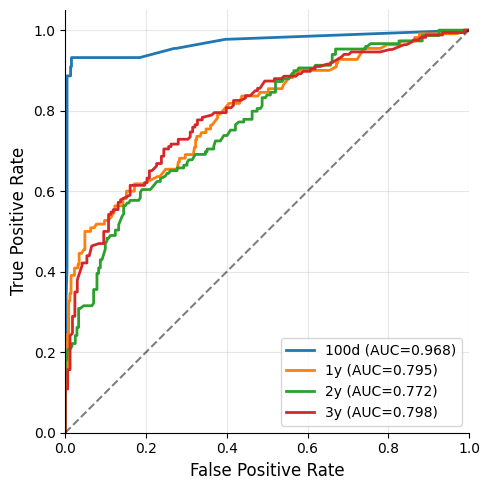

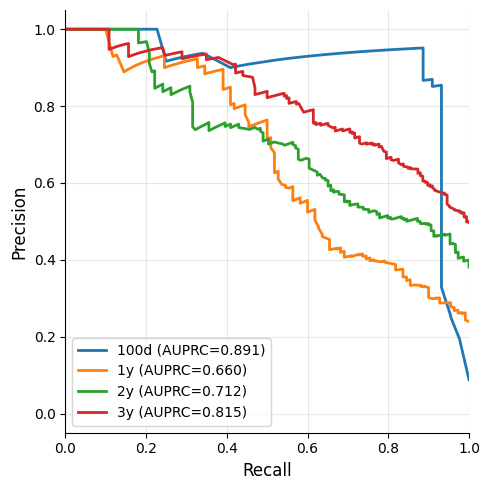

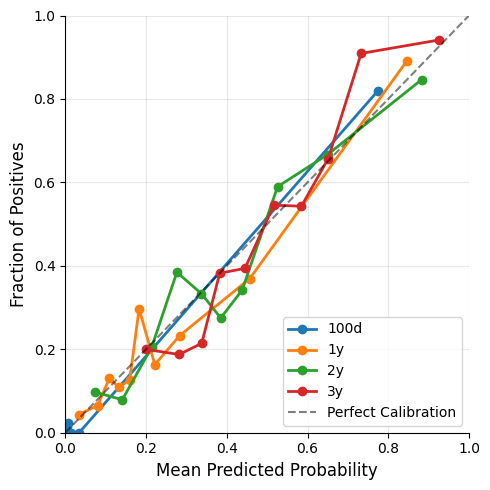

In [10]:
plot_data = [(y_true, y_prob, hname) for hname, y_true, y_prob in all_results]

# Combined subplots (original behavior)
# plot_performance_curves(plot_data)

# Separate plots  
plot_performance_curves(plot_data, figsize=(5, 5), separate_plots=True, show_full_curves=True, save_prefix='outputs/performance_', filetype='tiff')


In [11]:
# plot_data = [
#     (np.array(y_all_true_100d), np.array(y_all_prob_100d), '100d (RandomForest)'),
#     (np.array(y_all_true_1y), np.array(y_all_prob_1y), '1y (GradBoost)'),
#     (np.array(y_all_true_2y), np.array(y_all_prob_2y), '2y (LogReg)'),
#     (np.array(y_all_true_3y), np.array(y_all_prob_3y), '3y (GradBoost)')
# ] # this could be used as an alternative for the performance matrixs


Loading model for 100D horizon...
Transforming features...
Creating SHAP explainer for RandomForestClassifier...
Computing SHAP values...
Using SHAP values for positive class (class 1)
Plot saved to: outputs/shap_100d.tiff


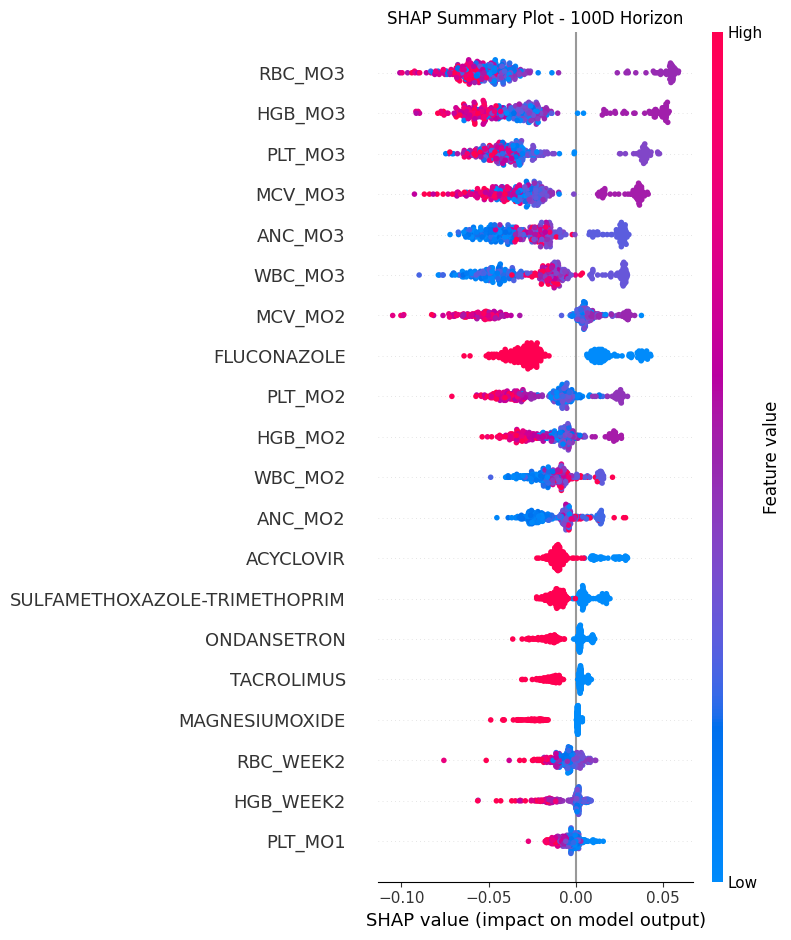

✓ SHAP analysis complete for 100D horizon
  Model type: RandomForestClassifier
Loading model for 1Y horizon...
Transforming features...
Creating SHAP explainer for GradientBoostingClassifier...
Computing SHAP values...
Using raw SHAP values
Plot saved to: outputs/shap_1y.tiff


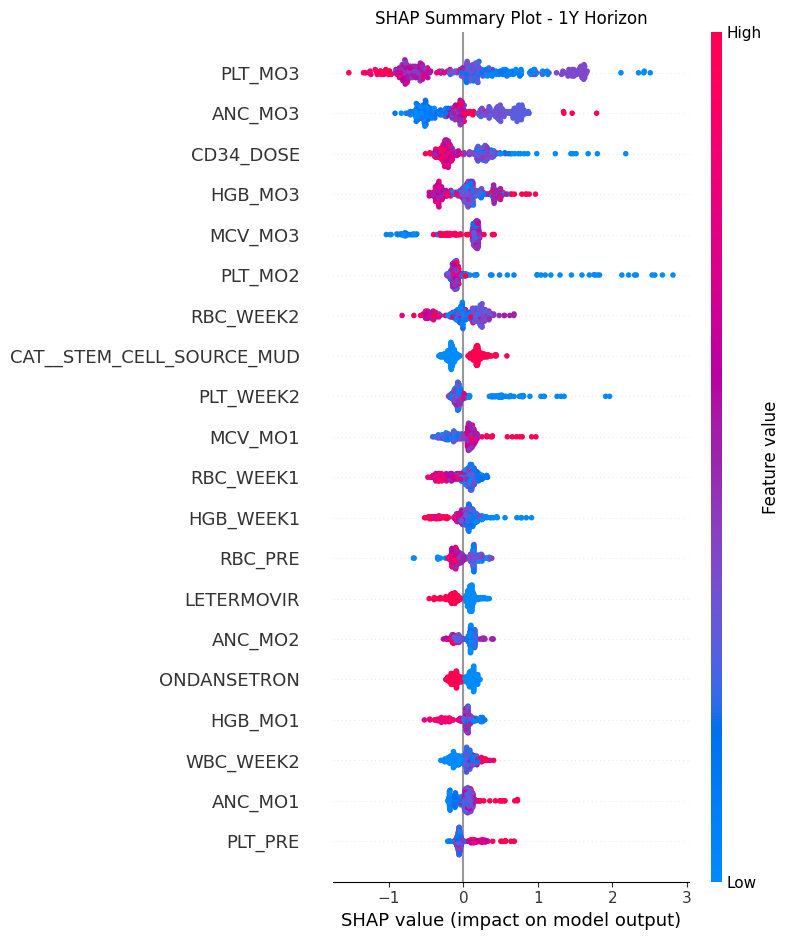

✓ SHAP analysis complete for 1Y horizon
  Model type: GradientBoostingClassifier
Loading model for 2Y horizon...
Transforming features...
Creating SHAP explainer for RandomForestClassifier...
Computing SHAP values...
Using SHAP values for positive class (class 1)
Plot saved to: outputs/shap_2y.tiff


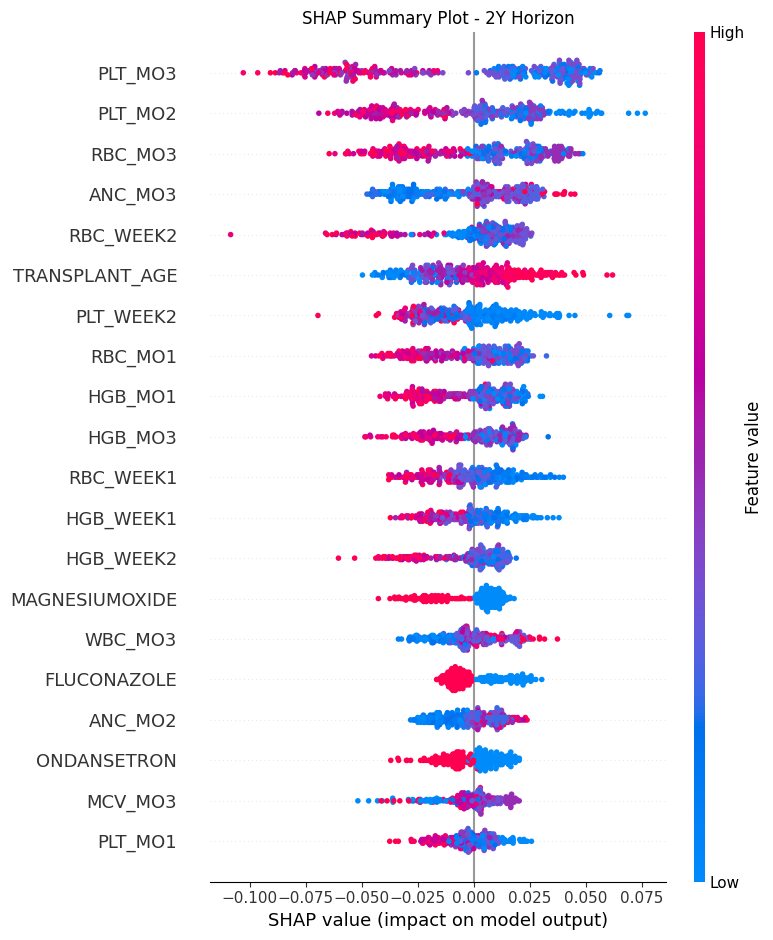

✓ SHAP analysis complete for 2Y horizon
  Model type: RandomForestClassifier
Loading model for 3Y horizon...
Transforming features...
Creating SHAP explainer for RandomForestClassifier...
Computing SHAP values...
Using SHAP values for positive class (class 1)
Plot saved to: outputs/shap_3y.tiff


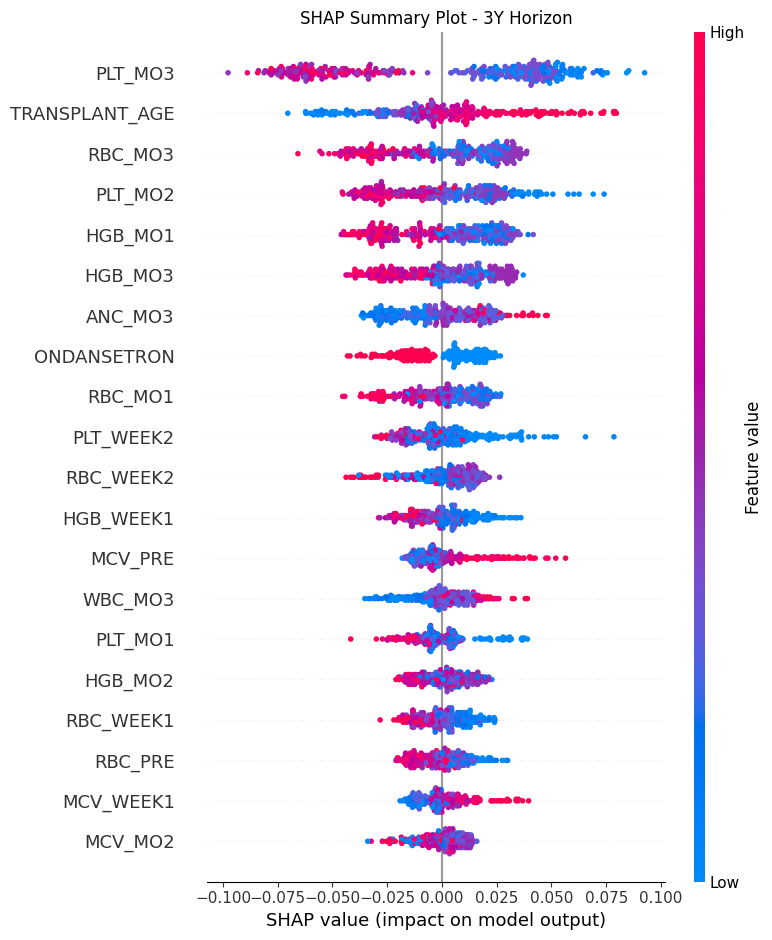

✓ SHAP analysis complete for 3Y horizon
  Model type: RandomForestClassifier


In [12]:
# plot_shap_all_horizons &
# Save individual plots
for horizon in ['100d', '1y', '2y', '3y']:
    plot_shap_for_horizon(best_models, horizon, Xh, save=True, filetype='tiff', save_prefix=f'outputs/shap_{horizon}'
                         )

In [13]:
# # perform shap analysis on the best model for 3y horizon
# best_model_3y = joblib.load(best_models['3y'])
# pipeline = best_model_3y.estimator
# X_transformed = pipeline.named_steps['prep'].transform(Xh)

# clf = pipeline.named_steps['clf']
# if isinstance(clf, (RandomForestClassifier, GradientBoostingClassifier)):
#     explainer = shap.TreeExplainer(clf)
# else:
#     explainer = shap.Explainer(clf, X_transformed)

# shap_values = explainer(X_transformed)
# feature_names = pipeline.named_steps['prep'].get_feature_names_out()
# clean_feature_names = [name.replace('num__','').replace('cat__oh__','') for name in feature_names]
# all_caps = [name.upper() for name in clean_feature_names]


# shap_values_class1 = shap_values.values[:, :, 1]
# shap.summary_plot(shap_values_class1, X_transformed, feature_names=all_caps, show=False, max_display=20)
# plt.title('SHAP Summary Plot for 3Y Horizon Model')
# plt.show()